In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import svdvals
import time
from pathlib import Path


from functions import (
    function_loss, 
    gradient, 
    LMO, 
    FW_standard, 
    FW_pairwise,
    FW_line_search
)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)

In [2]:

MOVIELENS_PATH = r"C:\Users\utente13\Desktop\FW_OptimizationProject\ml-latest-small\ratings.csv"  


df = pd.read_csv(
    MOVIELENS_PATH,
    sep=',',
    names=['user_id', 'movie_id', 'rating', 'timestamp'],
    engine='python'
    )

print(f"Dataset uploaded: {len(df)} ratings")
    

  
df = df.drop_duplicates(subset=['user_id', 'movie_id'])

Dataset uploaded: 100837 ratings


In [3]:
print("top 5 rows:")
print(df.head())
print("\n Columns name:")
print(df.columns.tolist())
print("\nInfo dataframe:")
print(df.info())

top 5 rows:
  user_id movie_id  rating  timestamp
0  userId  movieId  rating  timestamp
1       1        1     4.0  964982703
2       1        3     4.0  964981247
3       1        6     4.0  964982224
4       1       47     5.0  964983815

 Columns name:
['user_id', 'movie_id', 'rating', 'timestamp']

Info dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100837 entries, 0 to 100836
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    100837 non-null  object
 1   movie_id   100837 non-null  object
 2   rating     100837 non-null  object
 3   timestamp  100837 non-null  object
dtypes: object(4)
memory usage: 3.1+ MB
None


In [4]:
print(f"\nStatistics:")
print(f"  Users: {df['user_id'].nunique()}")
print(f"  Movies: {df['movie_id'].nunique()}")
print(f"  Ratings: {len(df)}")
print(f"  Sparsity: {100 * len(df) / (df['user_id'].nunique() * df['movie_id'].nunique()):.2f}%")
print(f"\nRating distribution:")
print(df['rating'].value_counts().sort_index())


Statistics:
  Users: 611
  Movies: 9725
  Ratings: 100837
  Sparsity: 1.70%

Rating distribution:
rating
0.5        1370
1.0        2811
1.5        1791
2.0        7551
2.5        5550
3.0       20047
3.5       13136
4.0       26818
4.5        8551
5.0       13211
rating        1
Name: count, dtype: int64


In [5]:
# Double header removing nd tyoe conversion
df = df.drop(0).reset_index(drop=True)
df['user_id'] = df['user_id'].astype(int)
df['movie_id'] = df['movie_id'].astype(int)
df['rating'] = df['rating'].astype(float)

print(df.head())
print(df.dtypes)

   user_id  movie_id  rating  timestamp
0        1         1     4.0  964982703
1        1         3     4.0  964981247
2        1         6     4.0  964982224
3        1        47     5.0  964983815
4        1        50     5.0  964982931
user_id        int64
movie_id       int64
rating       float64
timestamp     object
dtype: object


In [6]:
def create_rating_matrix(df, max_users=None, max_movies=None):
    """
    Creating matrix user-movie
    """
    if max_users:
        top_users = df['user_id'].value_counts().head(max_users).index
        df = df[df['user_id'].isin(top_users)]
    if max_movies:
        top_movies = df['movie_id'].value_counts().head(max_movies).index
        df = df[df['movie_id'].isin(top_movies)]
    
    # Creating mapping user_id/movie_id -> indice matrice
    user_ids = sorted(df['user_id'].unique())
    movie_ids = sorted(df['movie_id'].unique())
    
    user_map = {uid: i for i, uid in enumerate(user_ids)}
    movie_map = {mid: i for i, mid in enumerate(movie_ids)}
    
    # Empty matrix initialization
    n_users = len(user_ids)
    n_movies = len(movie_ids)
    R = np.zeros((n_users, n_movies))
    
    # Filling up with observed entries
    for _, row in df.iterrows():
        i = user_map[row['user_id']]
        j = movie_map[row['movie_id']]
        R[i, j] = row['rating']
    
    return R, user_map, movie_map

In [7]:
print(df.head())
print(df.dtypes)

   user_id  movie_id  rating  timestamp
0        1         1     4.0  964982703
1        1         3     4.0  964981247
2        1         6     4.0  964982224
3        1        47     5.0  964983815
4        1        50     5.0  964982931
user_id        int64
movie_id       int64
rating       float64
timestamp     object
dtype: object


In [8]:
#Creating matrix
print("Matrix creation rating...")
R_full, user_map, movie_map = create_rating_matrix(
    df, 
    max_users=None,  
    max_movies= None  
)

print(f"\nMatrice: {R_full.shape[0]} users × {R_full.shape[1]} movies")
print(f"Ratings observed: {np.count_nonzero(R_full)}")
print(f"Density: {100 * np.count_nonzero(R_full) / R_full.size:.2f}%")

Matrix creation rating...

Matrice: 610 users × 9724 movies
Ratings observed: 100836
Density: 1.70%


In [9]:
def train_test_split_matrix(R, test_ratio=0.2, random_state=42):
    """
    Dividing ratings in test and train
    """
    np.random.seed(random_state)
    
    # Finding indexes of entries
    observed_indices = np.argwhere(R > 0)
    n_observed = len(observed_indices)
    
    # Shuffle e split
    np.random.shuffle(observed_indices)
    n_test = int(n_observed * test_ratio)
    
    test_indices = observed_indices[:n_test]
    train_indices = observed_indices[n_test:]
    
    # Creating matrices
    R_train = np.zeros_like(R)
    R_test = np.zeros_like(R)
    
    for i, j in train_indices:
        R_train[i, j] = R[i, j]
    
    for i, j in test_indices:
        R_test[i, j] = R[i, j]
    
    return R_train, R_test


R_train, R_test = train_test_split_matrix(R_full, test_ratio=0.2)

print(f"Train set: {np.count_nonzero(R_train)} rating")
print(f"Test set: {np.count_nonzero(R_test)} rating")

Train set: 80669 rating
Test set: 20167 rating


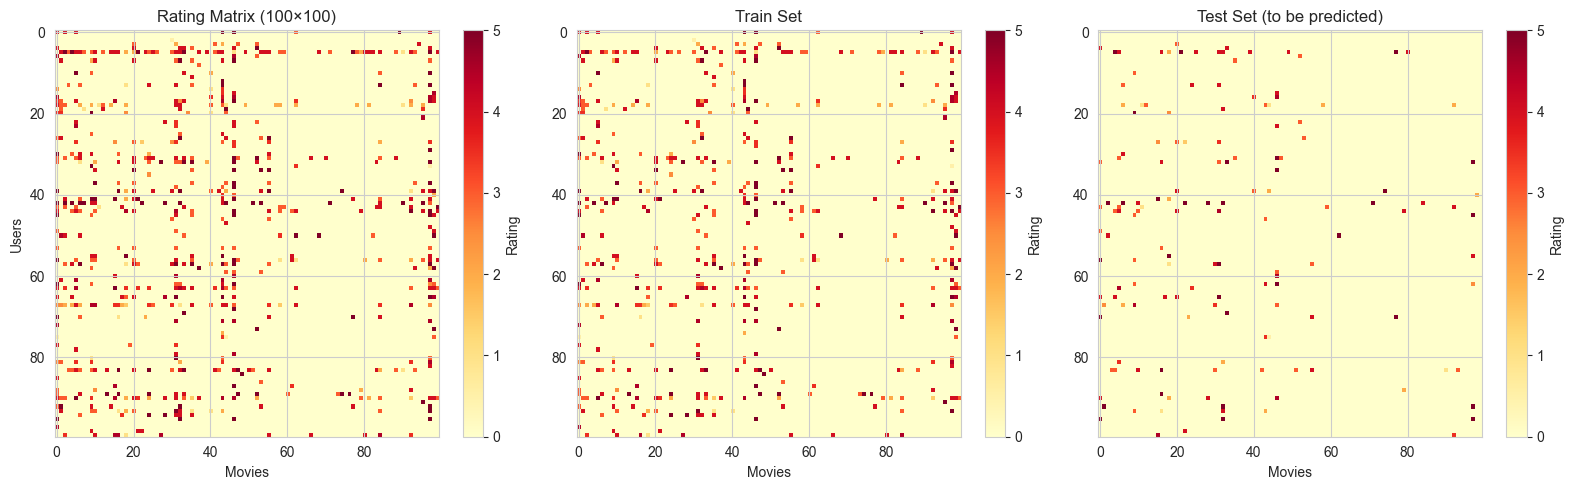

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Complete matrix
im1 = axes[0].imshow(R_full[:100, :100], cmap='YlOrRd', aspect='auto', vmin=0, vmax=5)
axes[0].set_title('Rating Matrix (100×100)')
axes[0].set_xlabel('Movies')
axes[0].set_ylabel('Users')
plt.colorbar(im1, ax=axes[0], label='Rating')

# Train matrix
im2 = axes[1].imshow(R_train[:100, :100], cmap='YlOrRd', aspect='auto', vmin=0, vmax=5)
axes[1].set_title('Train Set')
axes[1].set_xlabel('Movies')
plt.colorbar(im2, ax=axes[1], label='Rating')

# Test matrix
im3 = axes[2].imshow(R_test[:100, :100], cmap='YlOrRd', aspect='auto', vmin=0, vmax=5)
axes[2].set_title('Test Set (to be predicted)')
axes[2].set_xlabel('Movies')
plt.colorbar(im3, ax=axes[2], label='Rating')

plt.tight_layout()
plt.show()

Calcolo top-50 valori singolari...

Top 10 valori singolari:
[430.40843282 189.56431881 158.65670542 142.18753927 131.14937996
 126.08660274 116.88588876 111.63067924 108.05969999 103.78956435]


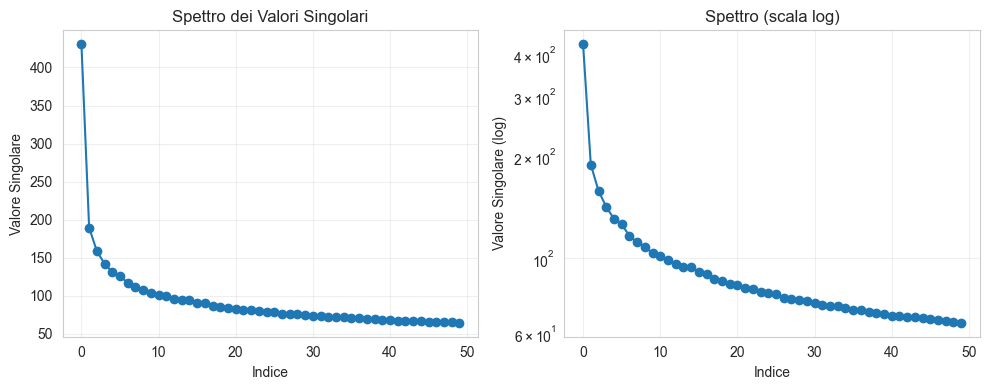


✓ Budget nucleare stimato: δ = 8000.00


In [ ]:
# ## 6. Stima del Budget Delta (Nuclear Norm)
# 
# Usiamo SVD troncata per stimare un buon valore di delta

# %%
# Calcola alcuni valori singolari
k_svd = min(50, min(R_train.shape) - 1)
print(f"Calcolo top-{k_svd} valori singolari...")

from scipy.sparse.linalg import svds
U, s, Vt = svds(R_train, k=k_svd)

print(f"\nTop 10 valori singolari:")
print(s[::-1][:10])

# Plot spettro
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(s[::-1], 'o-')
plt.xlabel('Indice')
plt.ylabel('Valore Singolare')
plt.title('Spettro dei Valori Singolari')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.semilogy(s[::-1], 'o-')
plt.xlabel('Indice')
plt.ylabel('Valore Singolare (log)')
plt.title('Spettro (scala log)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Stima delta come somma dei top-k valori singolari


print(f"\n✓ Budget nucleare stimato: δ = {delta:.2f}")

In [12]:
print("=" * 60)
print("TRAINING: Standard Frank-Wolfe (gamma = 2/(k+2))")
print("=" * 60)

rank_estimate = 20  
delta =8000 


start_time = time.time()

P_standard, loss_history_std, gap_history_std = FW_standard(
    R_train, 
    delta=delta,
    max_iter=150,
    tol=1e-5,
    init_type='zeros',
)

train_time_std = time.time() - start_time

print(f"\nTraining completed in {train_time_std:.2f} seconds")
print(f"  Iterations: {len(loss_history_std)}")
print(f"  Final train loss: {loss_history_std[-1]:.4f}")


TRAINING: Standard Frank-Wolfe (gamma = 2/(k+2))

Training completed in 56.68 seconds
  Iterations: 150
  Final train loss: 1.4866


In [13]:
print("=" * 60)
print("TRAINING: Frank-Wolfe with Line Search")
print("=" * 60)

start_time = time.time()

P_linesearch, loss_history_ls, gap_history_ls = FW_line_search(
    R_train,
    delta=delta,
    max_iter=150,
    tol=1e-5
)

train_time_ls = time.time() - start_time

print(f"\nTraining {train_time_ls:.2f} seconds")
print(f"Iterations: {len(loss_history_ls)}")
print(f"Final train loss: {loss_history_ls[-1]:.4f}")

TRAINING: Frank-Wolfe with Line Search

Training 139.07 seconds
Iterations: 150
Final train loss: 0.4743


In [14]:
print("=" * 60)
print("TRAINING: Pairwise Frank-Wolfe")
print("=" * 60)

start_time = time.time()

P_pairwise, loss_history_pw, gap_history_pw = FW_pairwise(
    R_train,
    delta=delta,
    max_iter=150,
    tol=1e-5
)

train_time_pw = time.time() - start_time

print(f"\n Training in {train_time_pw:.2f} seconds")
print(f"Iterations: {len(loss_history_pw)}")
print(f"Final training loss: {loss_history_pw[-1]:.4f}")


TRAINING: Pairwise Frank-Wolfe

 Training in 993.73 seconds
Iterations: 150
Final training loss: 0.8091


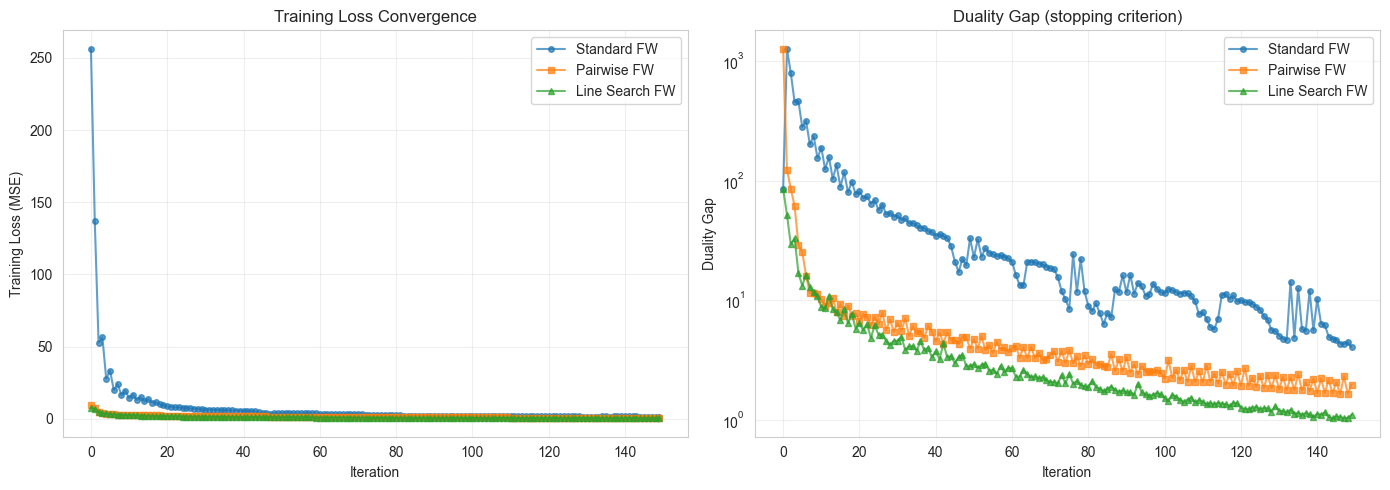

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training loss
axes[0].plot(loss_history_std, 'o-', label='Standard FW', alpha=0.7, markersize=4)
axes[0].plot(loss_history_pw, 's-', label='Pairwise FW', alpha=0.7, markersize=4)
axes[0].plot(loss_history_ls, '^-', label='Line Search FW', alpha=0.7, markersize=4)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Training Loss (MSE)')
axes[0].set_title('Training Loss Convergence')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Duality gap
axes[1].semilogy(gap_history_std, 'o-', label='Standard FW', alpha=0.7, markersize=4)
axes[1].semilogy(gap_history_pw, 's-', label='Pairwise FW', alpha=0.7, markersize=4)
axes[1].semilogy(gap_history_ls, '^-', label='Line Search FW', alpha=0.7, markersize=4)
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Duality Gap')
axes[1].set_title('Duality Gap (stopping criterion)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

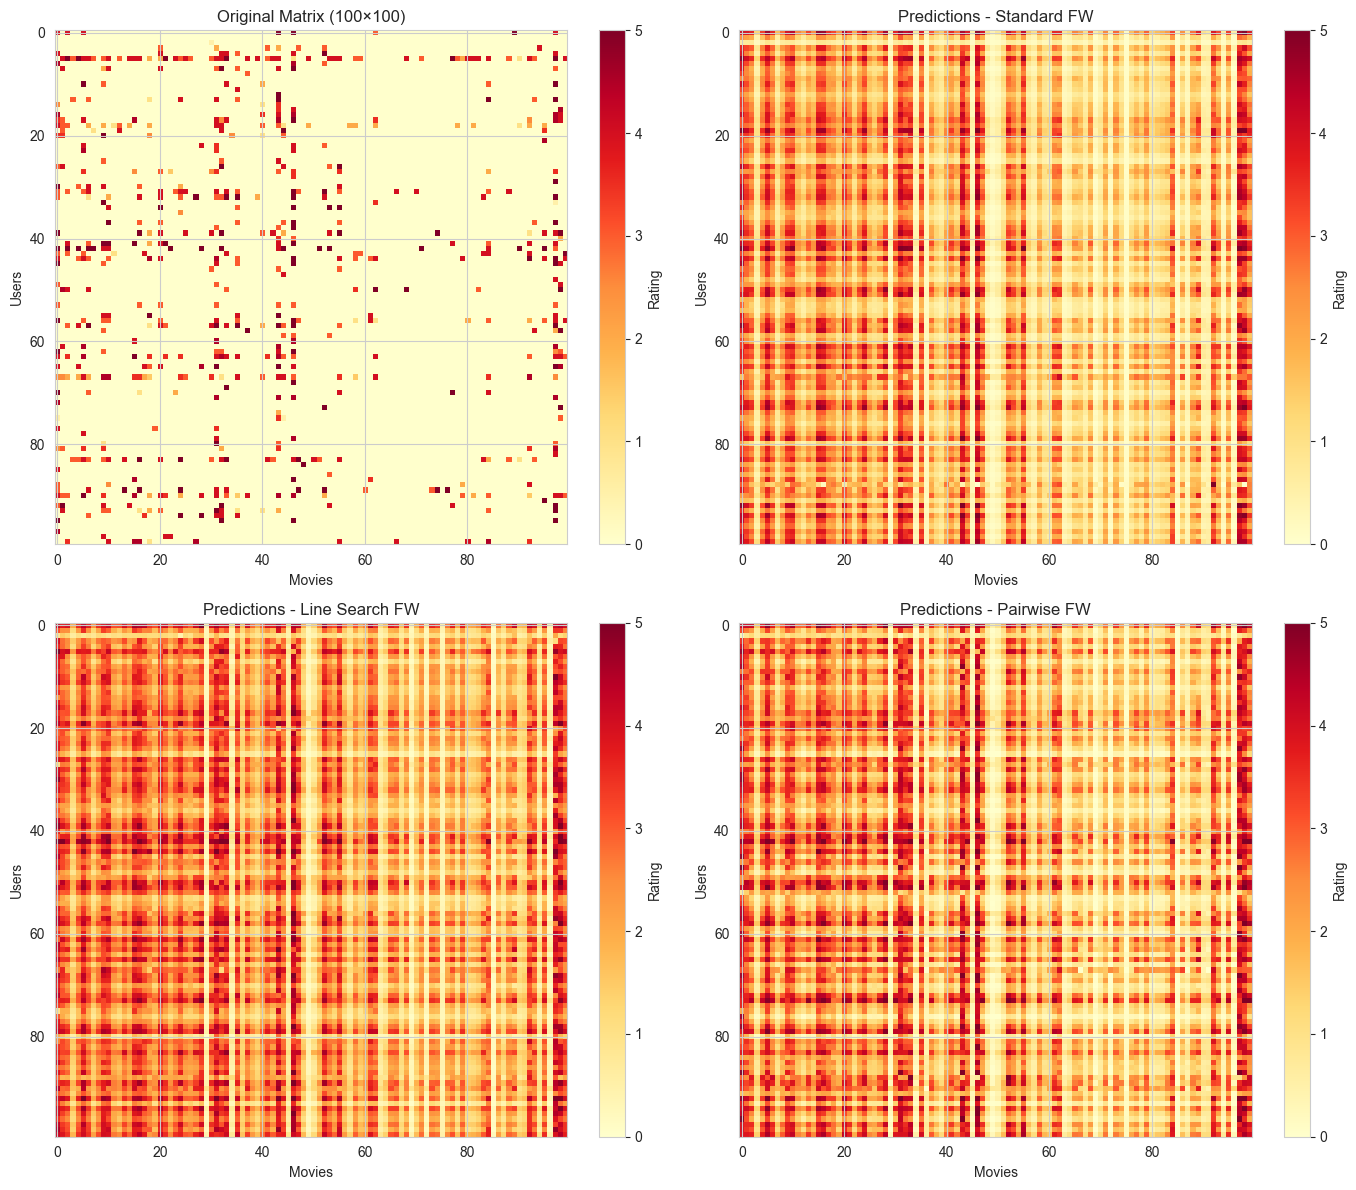

In [19]:
# Original vs Predictions
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

im1 = axes[0, 0].imshow(R_full[:100, :100], cmap='YlOrRd', aspect='auto', vmin=0, vmax=5)
axes[0, 0].set_title('Original Matrix (100×100)')
axes[0, 0].set_xlabel('Movies')
axes[0, 0].set_ylabel('Users')
plt.colorbar(im1, ax=axes[0, 0], label='Rating')

im2 = axes[0, 1].imshow(P_standard[:100, :100], cmap='YlOrRd', aspect='auto', vmin=0, vmax=5)
axes[0, 1].set_title('Predictions - Standard FW')
axes[0, 1].set_xlabel('Movies')
axes[0, 1].set_ylabel('Users')
plt.colorbar(im2, ax=axes[0, 1], label='Rating')

im3 = axes[1, 0].imshow(P_linesearch[:100, :100], cmap='YlOrRd', aspect='auto', vmin=0, vmax=5)
axes[1, 0].set_title('Predictions - Line Search FW')
axes[1, 0].set_xlabel('Movies')
axes[1, 0].set_ylabel('Users')
plt.colorbar(im3, ax=axes[1, 0], label='Rating')

im4 = axes[1, 1].imshow(P_pairwise[:100, :100], cmap='YlOrRd', aspect='auto', vmin=0, vmax=5)
axes[1, 1].set_title('Predictions - Pairwise FW')
axes[1, 1].set_xlabel('Movies')
axes[1, 1].set_ylabel('Users')
plt.colorbar(im4, ax=axes[1, 1], label='Rating')

plt.tight_layout()
plt.show()